In [3]:
import tensorflow as tf
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))
strategy = tf.distribute.TPUStrategy(resolver)


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [12]:
import cv2
import numpy as np
import os
from tqdm.notebook import tqdm
import tensorflow as tf

# Read image
def load_image(image_dir, image_name):
    im = cv2.imread(os.path.join(image_dir, image_name))
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    scale_percent = 60 # percent of original size
    width = int(im.shape[1] * scale_percent / 100)
    height = int(im.shape[0] * scale_percent / 100)
    dim = (width, height)
    
    # resize image
    im = cv2.resize(im, dim, interpolation = cv2.INTER_AREA)
    return im

def load_all_images(image_dir, image_names):
    images = []
    # convert to tqdm to see progress
    for image_name in image_names:
        print("Saving image: ", image_name)
        images.append(load_image(image_dir, image_name))
    return images


In [4]:
ims = []
for i in range(0, 6):
    image_dir = "./Monthly"
    # get each set of 50 images
    image_names = sorted(os.listdir(image_dir))[i*50:(i+1)*50]
    ims.append(load_all_images(image_dir, image_names))


np.savez("images_train.npz".format(i), images=ims[:3])
np.savez("images_val.npz".format(i), images=ims[3:4])

FileNotFoundError: ignored

In [20]:
with tf.device("CPU"):
  train_dataset = np.load('/content/drive/MyDrive/images_train.npz', allow_pickle=True)['images']
  val_dataset = np.load('/content/drive/MyDrive/images_train.npz', allow_pickle=True)['images']
  train_dataset = np.expand_dims(train_dataset, axis=-1)
  val_dataset = np.expand_dims(val_dataset, axis=-1)

In [21]:
with tf.device("CPU"):
  train_dataset = train_dataset / 255
  val_dataset = val_dataset / 255

In [22]:
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y

In [23]:
with tf.device("CPU"):
  x_train, y_train = create_shifted_frames(train_dataset)
  x_val, y_val = create_shifted_frames(val_dataset)

In [24]:
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Training Dataset Shapes: (6, 9, 204, 409, 1), (6, 9, 204, 409, 1)
Validation Dataset Shapes: (6, 9, 204, 409, 1), (6, 9, 204, 409, 1)


In [25]:
import matplotlib.pyplot as plt

# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(4, 5, figsize=(10, 8))

# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(train_dataset[data_choice][idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()

IndexError: ignored

Error in callback <function flush_figures at 0x7f2855481f70> (for post_execute):


KeyboardInterrupt: ignored

In [26]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.debugging.set_log_device_placement(True)

# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, *x_train.shape[2:]))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),
)

In [27]:
# Define some callbacks to improve training.
tf.debugging.set_log_device_placement(False)
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 10
batch_size = 1

# Fit the model to the training data.
model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/10
6/6 [==============================] - 26s 3s/step - loss: 0.4828 - val_loss: 0.6884 - lr: 0.0010
Epoch 2/10
6/6 [==============================] - 14s 3s/step - loss: 0.4024 - val_loss: 0.6853 - lr: 0.0010
Epoch 3/10
6/6 [==============================] - 12s 2s/step - loss: 0.3936 - val_loss: 0.6832 - lr: 0.0010
Epoch 4/10
6/6 [==============================] - 13s 2s/step - loss: 0.3888 - val_loss: 0.6826 - lr: 0.0010
Epoch 5/10
6/6 [==============================] - 15s 3s/step - loss: 0.3855 - val_loss: 0.6811 - lr: 0.0010
Epoch 6/10
6/6 [==============================] - 15s 3s/step - loss: 0.3832 - val_loss: 0.6797 - lr: 0.0010
Epoch 7/10
6/6 [==============================] - 15s 3s/step - loss: 0.3819 - val_loss: 0.6783 - lr: 0.0010
Epoch 8/10
6/6 [==============================] - 12s 2s/step - loss: 0.3805 - val_loss: 0.6769 - lr: 0.0010
Epoch 9/10
6/6 [==============================] - 15s 3s/step - loss: 0.3799 - val_loss: 0.6753 - lr: 0.0010
Epoch 10/10
6/6 [==

(5, 204, 409, 1)
1/1 [==============================] - 0s 414ms/step
(5, 204, 409, 1)
(1, 204, 409, 1)
(6, 204, 409, 1)
1/1 [==============================] - 0s 373ms/step
(6, 204, 409, 1)
(1, 204, 409, 1)
(7, 204, 409, 1)
1/1 [==============================] - 0s 431ms/step
(7, 204, 409, 1)
(1, 204, 409, 1)
(8, 204, 409, 1)
1/1 [==============================] - 0s 483ms/step
(8, 204, 409, 1)
(1, 204, 409, 1)
(9, 204, 409, 1)
1/1 [==============================] - 0s 225ms/step
(9, 204, 409, 1)
(1, 204, 409, 1)
(10, 204, 409, 1)


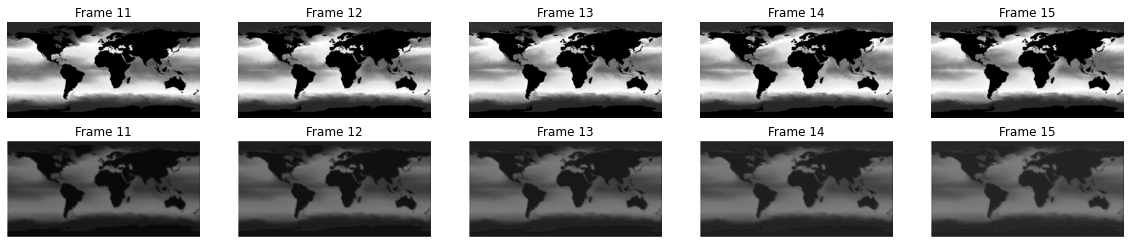

In [39]:
# Select a random example from the validation dataset.
example = val_dataset[np.random.choice(range(len(val_dataset)), size=1)[0]]

# Pick the first/last ten frames from the example.
frames = example[:5, ...]
original_frames = example[:5, ...]
print(original_frames.shape)

# Predict a new set of 10 frames.
for _ in range(5):
    # Extract the model's prediction and post-process it.
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    print(new_prediction.shape)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)
    print(predicted_frame.shape)

    # Extend the set of prediction frames.
    frames = np.concatenate((frames, predicted_frame), axis=0)
    print(frames.shape)

# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 5, figsize=(20, 4))

# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(original_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Plot the new frames.
new_frames = frames[5:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Display the figure.
plt.show()